# A|B Testing Template
 Roolout Experiments
 
 background: 
 - https://towardsdatascience.com/bayesian-a-b-testing-with-python-the-easy-guide-d638f89e0b8a
 - https://www.crosstab.io/articles/staged-rollout-analysis
 
 

## Python Libraries

In [3]:
import pandas as pd

import sys
sys.path.append('C:/Users\mvinasco/Documents/utilities')
import connect_redshift as crs
engine = crs.RedShift_engine()

import sqlalchemy

import numpy as np

In [6]:
import xlwings as xw

def writes_df_excel(sht, df, rangename):
    # clears existing data
    x0 = sht.range('A1').end('down')
    y0 = sht.range('A1').end('right')
    sht.range(x0,y0).clear()

    sht.range('A1').options(index=False).value  = df
    tbl_range = sht.range("A1").expand('table')
    sht.api.ListObjects.Add(1, sht.api.Range(tbl_range.address))
    
    sht.range(tbl_range).expand().name = rangename

In [16]:
from scipy.stats import beta
import numpy as np
from calc_prob import calc_prob_between

## Data Classes

In [1]:
from dataclasses import dataclass

@dataclass
class Experiment:
    Campaign_name: str
    Camp_description: str
    Campaign_API_Identifier: str
    control_id: str
    variant_id1_name: str
    variant_id1: str
    send_date: str

# Email campaigns
# default braze tables

Campaign1 = Experiment(
    'enrolled_customers',
    "Retroactive_Campaign2",
    'fc78aabd-ace5-4dd0-b5a7-71cb1aaf65b5',
    'b3c930e3-c438-41b2-9fd2-1feebda39b12',
    'Morpheus',
    '86fffc3b-7de1-4f0e-a6c5-42d94e3693fa',
     "2021-02-01"
)


## Query

In [4]:
query1 = f"""

with send_data AS (
        select usertoken, sl.campaign_name campaign_name_email, 
        date_trunc('day',sl.send_date) send_date_email,
        mailing_id,
    case sl.message_id
        when '{Campaign1.variant_id1}' then '{Campaign1.variant_id1_name}'
        else 'other'
    end as variant_name_email
    
from email_ops.strongview_email_send_log sl
where sl.campaign_id IN ('{Campaign1.Campaign_API_Identifier}')
and sl.send_date >= '{Campaign1.send_date}'


UNION ALL

select user_token as usertoken, campaign_name campaign_name_email, 
      date_trunc('day', event_datetime)  as send_date_email,
      '' as mailing_id,
        'control_group' as variant_name_email
    from email_ops.braze_email_enroll_in_control
where campaign_id IN ('{Campaign1.Campaign_API_Identifier}')

),

cash_enrolled as (
    select c.usertoken,
           enrollment_timestamp::date as enrollment_timestamp,
           convert_timezone('America/Los_Angeles', enrollment_timestamp) as enrollment_timestamp_pt
    from sesame_cash.sesame_cash_enrollment enr
    join send_data c
        using(usertoken)
    where enrollment_status = 'REGISTERED'
        and effective_end_datetime = '2100-01-01'
        and enrollment_timestamp >= '{Campaign1.send_date}'
),

funded_users as (
        select p.usertoken,
               min(date_trunc('day',transaction_datetime)) as funding_date
        from sesame_cash.posted_transaction p
        join send_data c
        using(usertoken)
        where p.transaction_classification_group = 'Money Load'
        and transaction_datetime >=  '{Campaign1.send_date}'
        group by 1
    ),
    
retention as (
    select mau.usertoken, mau.activity_month_los_angeles
    from send_data c
    join measures.monthly_active_users mau
        using(usertoken)
   
    where mau.activity_month_los_angeles = date_trunc('month', dateadd(month,1, '{Campaign1.send_date}'))   
),

clk_apply as (
             select si.usertoken,  
                    count(distinct si.mailing_id) as sends,
                    count(distinct c.clickid) AS Click_Apply
             from send_data si
             left outer join public.click_applies_properties c
                on si.usertoken = c.usertoken
                and  COALESCE(c.mailing_id,
                             SUBSTRING(c.ref_code, LEN(c.ref_code) - position('_' in reverse(ref_code)) + 2,
                                       50))  = si.mailing_id
                 and  date_trunc('month', c.createdate) >= '{Campaign1.send_date}'
            group by 1 )
    
select * 
from send_data sd
left outer join funded_users using(usertoken)
left outer join cash_enrolled using(usertoken)
left outer join retention using(usertoken)
left outer join clk_apply using(usertoken)
"""


## Execute SQL

In [5]:
experm_df = pd.read_sql_query(sqlalchemy.text(query1), engine)
experm_df.head()

,usertoken,campaign_name_email,send_date_email,mailing_id,variant_name_email,funding_date,enrollment_timestamp,enrollment_timestamp_pt,activity_month_los_angeles,sends,click_apply
0,871b99f8-1620-4808-befc-586516925d25,f - CASH - Enroll - Retroactive $10 - Feb 2021,2021-02-04,b44fced3261b6caac5753012d0efc682,Morpheus,NaT,None,NaT,2021-03-01,1,0
1,871b99f8-1620-4808-befc-586516925d25,f - CASH - Enroll - Retroactive $10 - Feb 2021,2021-02-04,b44fced3261b6caac5753012d0efc682,Morpheus,NaT,None,NaT,2021-03-01,1,0
2,ba641aa6-1305-413e-8332-76e0751b939b,f - CASH - Enroll - Retroactive $10 - Feb 2021,2021-02-04,b44fced3261b6caac5753012d0efc682,Morpheus,NaT,None,NaT,2021-03-01,1,0
3,b3ef1781-95eb-464f-a4c3-3778e0229945,f - CASH - Enroll - Retroactive $10 - Feb 2021,2021-02-04,b44fced3261b6caac5753012d0efc682,other,NaT,None,NaT,NaT,1,0
4,a455334c-0770-4989-9b90-0bfce94e9507,f - CASH - Enroll - Retroactive $10 - Feb 2021,2021-02-04,b44fced3261b6caac5753012d0efc682,other,NaT,None,NaT,2021-03-01,1,0


In [9]:
pd.pivot_table(experm_df, index=['campaign_name_email', 'variant_name_email'], values='usertoken',
              aggfunc='count')

usertoken
campaign_name_email                            variant_name_email           
f - CASH - Enroll - Retroactive $10 - Feb 2021 Morpheus               114760
                                               control_group           57113
                                               other                  113907

# Data Exploration

In [10]:
experm_df2= experm_df[experm_df['variant_name_email'] != 'other']

In [11]:
users_pt = pd.pivot_table(experm_df2, index=['campaign_name_email', 'variant_name_email'], values='usertoken', 
               aggfunc='count', fill_value=0, dropna=False)
users_pt

usertoken
campaign_name_email                            variant_name_email           
f - CASH - Enroll - Retroactive $10 - Feb 2021 Morpheus               114760
                                               control_group           57113

In [12]:
enrolled_df = (experm_df2[experm_df2['enrollment_timestamp'].notnull()])
enrolled_pt = pd.pivot_table(enrolled_df,  index=['campaign_name_email', 'variant_name_email'], 
                             values='usertoken', aggfunc='count')
enrolled_pt

usertoken
campaign_name_email                            variant_name_email           
f - CASH - Enroll - Retroactive $10 - Feb 2021 Morpheus                 4768
                                               control_group            1856

In [78]:
enrolled_pt / users_pt.values

usertoken
campaign_name_email                            variant_name_email           
f - CASH - Enroll - Retroactive $10 - Feb 2021 Morpheus             0.041548
                                               control_group        0.032497

In [13]:
fund_df = (experm_df2[experm_df2['funding_date'].notnull()])
fund_pt = pd.pivot_table(fund_df,  index=['campaign_name_email', 'variant_name_email'], 
                         values='usertoken', aggfunc='count')
fund_pt

usertoken
campaign_name_email                            variant_name_email           
f - CASH - Enroll - Retroactive $10 - Feb 2021 Morpheus                  930
                                               control_group             247

In [79]:
fund_pt / users_pt.values

usertoken
campaign_name_email                            variant_name_email           
f - CASH - Enroll - Retroactive $10 - Feb 2021 Morpheus             0.008104
                                               control_group        0.004325

In [14]:
retent_df = (experm_df2[experm_df2['activity_month_los_angeles'].notnull()])
rentent_pt = pd.pivot_table(retent_df,  index=['campaign_name_email', 'variant_name_email'], 
                            values='usertoken', aggfunc='count')

rentent_pt

usertoken
campaign_name_email                            variant_name_email           
f - CASH - Enroll - Retroactive $10 - Feb 2021 Morpheus                99486
                                               control_group           49348

In [15]:
clk_apply_df = (experm_df2[experm_df2['click_apply'] >= 1.0])
clk_apply__pt = pd.pivot_table(clk_apply_df,  index=['campaign_name_email', 'variant_name_email'], 
                            values='usertoken', aggfunc='count')
clk_apply__pt

usertoken
campaign_name_email                            variant_name_email           
f - CASH - Enroll - Retroactive $10 - Feb 2021 Morpheus                   17
                                               control_group               4

# A|B Analysis

## Bayesian Function

In [147]:
def calc_beta_mode(a, b):
    '''this function calculate the mode (peak) of the Beta distribution'''
    return (a-1)/(a+b-2)


def beta_test(sum_control, sum_test, imps_ctrl, convs_ctrl, imps_test, convs_test):
    # here we create the Beta functions for the two sets
    a_C, b_C = convs_ctrl + sum_control, imps_ctrl - convs_ctrl + sum_control
    beta_C = beta(a_C, b_C)

    a_T, b_T = convs_test + sum_test, imps_test - convs_test + sum_test
    beta_T = beta(a_T, b_T)

    #calculating the lift
    lift=(beta_T.mean()-beta_C.mean())/beta_C.mean()
    lift_pts =(beta_T.mean()-beta_C.mean())
    

    #calculating the probability for Test to be better than Control
    if lift < 0:
        prob=calc_prob_between(beta_C, beta_T)
    else:
        prob=calc_prob_between(beta_T, beta_C)

    return beta_T.mean(), beta_C.mean(), lift_pts, lift,  prob, beta_T, beta_C

## A|B test Set Up

In [58]:
CONTROL = 'control_group'
VARIATIONS = ['Morpheus']
CAMPAIGN = 'f - CASH - Enroll - Retroactive $10 - Feb 2021'

kpi_names =  ['enrollments', 'funded']
kpi_pt = [ enrolled_pt, fund_pt]

# base_pt is the denominator of the rate, eg fund/enrollment, enrollment/users
base_pt = [users_pt, users_pt]

In [124]:
# Define factor to sum to Betas
# alpha = conversions + factor
# beta = impresions - conversions + factor

# By default these factors can be 1
dict_of_fac = {v: {m:1 for m in kpi_names} for v in VARIATIONS + [CONTROL]}

# it can be set to a factor of the same order of magnitude that the observed data
# TRY BOTH and see if its not far from observed data !!!

use_default_one = True

# proportion of observed data to use as prior; 
# eems that low values produce results closer to observed rates
dprior = 0.1

if not use_default_one:
    for vari in VARIATIONS + [CONTROL]:
        for k, m in zip(kpi_pt,kpi_names):
                dict_of_fac[vari][m] = int(dprior * k.loc[CAMPAIGN, vari].values[0])


In [125]:
dict_of_fac

{'Morpheus': {'enrollments': 1, 'funded': 1},
 'control_group': {'enrollments': 1, 'funded': 1}}

In [148]:
list_of_stats = []
cols = ['campaign','variation', 'metric', 'mean_Test','mean_Control', 'lift_pts' ,
        'lift_prct', 'probability']


for variation in VARIATIONS:
    for metric, pt, b_pt in zip(kpi_names, kpi_pt, base_pt):
        
        imps_ctrl, convs_ctrl = b_pt.loc[CAMPAIGN, CONTROL],   pt.loc[CAMPAIGN, CONTROL]
        imps_test, convs_test = b_pt.loc[CAMPAIGN, variation],   pt.loc[CAMPAIGN, variation]

        # expected metric
        sum_control = dict_of_fac[CONTROL][metric]
        sum_var =  dict_of_fac[variation][metric]
        

        T_avg, C_avg, lift_pts, lift, prob, beta_T, beta_C = beta_test(sum_control,
                                                       sum_var, imps_ctrl[0], convs_ctrl[0],
                                                       imps_test[0], convs_test[0])

        list_of_stats.append([CAMPAIGN, variation, metric, T_avg, C_avg, lift_pts, lift, prob])
            
        stats_df = pd.DataFrame(list_of_stats, columns=cols)

In [149]:
stats_df

,campaign,variation,metric,mean_Test,mean_Control,lift_pts,lift_prct,probability
0,f - CASH - Enroll - Retroactive $10 - Feb 2021,Morpheus,enrollments,0.041556,0.032513,0.009042,0.278108,1.0
1,f - CASH - Enroll - Retroactive $10 - Feb 2021,Morpheus,funded,0.008112,0.004342,0.003770,0.868315,1.0


In [166]:
probab_test_under_thr = beta_T.cdf(0.007)
probab_test_under_thr

5.472932150836546e-06

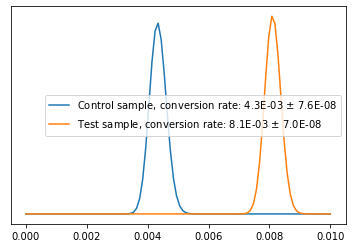

In [128]:
import matplotlib.pyplot as plt


def plot(betas, names, linf=0, lsup=0.01):
    '''this function plots the Beta distribution'''
    x=np.linspace(linf,lsup, 100)
    for f, name in zip(betas,names) :
        y=f.pdf(x) #this for calculate the value for the PDF at the specified x-points
        y_mode=calc_beta_mode(f.args[0], f.args[1])
        y_var=f.var() # the variance of the Beta distribution
        plt.plot(x,y, label=f"{name} sample, conversion rate: {y_mode:0.1E} $\pm$ {y_var:0.1E}")
        plt.yticks([])
    plt.legend()
    plt.show()

    
plot([beta_C, beta_T], names=["Control", "Test"])

In [100]:
metric

'funded'

## Export to Excel

In [167]:
wb = xw.Book(r'C:\Users\mvinasco\Documents\Ad Hocs\Axiom\Acxiom_Analyis.xlsx')

In [ ]:
sht = wb.sheets['experiment']
writes_df_excel(sht, df=stats_df, rangename='experiment')